### Import Libraries

In [1]:
import numpy as np
import xarray as xr
import hsmm_mvpy as hmp
import matplotlib.pyplot as plt
from pathlib import Path
from mne import channels
from shared.utilities import SAT1_STAGES_ACCURACY, SAT1_STAGES_SPEED, SAT2_STAGES_ACCURACY, SAT2_STAGES_SPEED, AR_STAGES

2023-07-04 12:21:39.546387: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 12:21:40.334416: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Load data

In [3]:
# Amount of cores to use in multiprocessing
cpus = 24

# Load complete SAT1 dataset
eeg_data = xr.load_dataset('data/sat1/data.nc')

# Set up montage according to 10-20 system
montage = dict(channels.make_standard_montage('easycap-M1').get_positions())['ch_pos']

# Load x and y positions of electrodes
positions = np.array([montage[x][:2] for x in eeg_data['electrodes'].values])

output_path = Path('data/sat1/')


### Prepare data

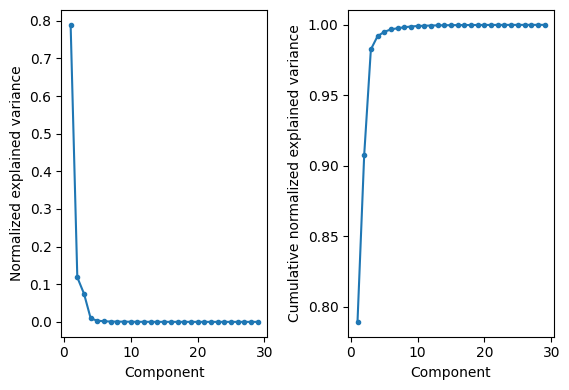

In [4]:
# Transform data into principal component (PC) space
# will ask in a pop-up how many components to keep
# selection depends on data size, choose number at cutoff (90/99%) or at 'elbow' point
hmp_data = hmp.utils.transform_data(eeg_data)

### Initialize models

In [5]:
hmp_accuracy_data = hmp.utils.condition_selection(hmp_data, eeg_data, 'AC')
model_accuracy = hmp.models.hmp(hmp_accuracy_data, eeg_data, event_width=50, cpus=cpus,
                                 sfreq=eeg_data.sfreq, estimate_magnitudes=False)

hmp_speed_data = hmp.utils.condition_selection(hmp_data, eeg_data, 'SP')
model_speed = hmp.models.hmp(hmp_speed_data, eeg_data, event_width=50, cpus=cpus,
                              sfreq=eeg_data.sfreq, estimate_magnitudes=False)

#### Regular fitting

In [6]:
fit_accuracy = model_accuracy.fit(step=1)
fit_speed = model_speed.fit(step=1)

  0%|          | 0/96 [00:00<?, ?it/s]

Transition event 2 found around sample 30
Transition event 3 found around sample 51
Transition event 4 found around sample 65
Estimating 4 events model
Parameters estimated for 4 events model


  0%|          | 0/58 [00:00<?, ?it/s]

Transition event 2 found around sample 27
Transition event 3 found around sample 51
Estimating 3 events model
Parameters estimated for 3 events model


In [7]:
# Takes a model and the probabilities of events occuring within the dataset the model was initiated on
# and returns an ndarray of shape samples x time x #electrodes
# length of labels must be equal to amount of events
def process_model(model, eeg_data, labels):
    n_events = len(model.event)
    if len(labels) != n_events:
        raise ValueError('Amount of labels is not equal to amount of events, adjust labels parameter')
    
    # Set up output datatypes
    event_locations = model.eventprobs.idxmax(dim='samples')
    stage_data = []
    stage_labels = []
    participant_labels = []

    # For every known set of event locations, find the EEG data belonging to that trial (epoch) and participant
    for locations, data in zip(event_locations, model.trial_x_participant):
        data = data.item()
        locations = locations.values
        print(f'Processing participant {data[0]} and epoch {data[1]}')
        t_x_p_data = eeg_data.sel(participant=data[0], epochs=data[1])
        # TODO Maybe not reliable enough, what if electrode 0 (Fp1) is working but others are not
        RT_sample = int(t_x_p_data.isnull().argmax('samples').data[0])

        for j, location in enumerate(locations):
            # Slice from known event location n to known event location n + 1
            # unless it is the last event, then slice from known event location n to reaction time
            samples_slice = slice(location, locations[j + 1]) if j != n_events - 1 else slice(location, RT_sample - 1)
            
            # Do not record final stage if the last event bump is after the recorded reaction time
            # In this case, previous slices will have contained NaN values and have been skipped
            if j == n_events - 1 and location > RT_sample:
                continue

            eeg_slice = t_x_p_data.sel(samples=samples_slice)['data']

            # Disregard slices with NaN/None values
            if eeg_slice.isnull().any():
                continue

            # Pad data to 'max' sample length
            # TODO: Look into max sample length
            stage_data.append(eeg_slice.pad(pad_width={'samples': (0, 210 - len(eeg_slice['samples']))}, mode='constant', constant_values=0))
            stage_labels.append(labels[j])
            participant_labels.append(data[0])
            
    stage_data = np.array(stage_data, dtype=np.float64)
    return stage_data, stage_labels, participant_labels


# Save data as .npz file containing both the data and belonging labels
def save_data(data, labels, participants, name):
    np.savez(output_path / name, data = data, labels = labels, participants=participants)

In [8]:
acc_data, acc_labels, acc_part = process_model(fit_accuracy, eeg_data, SAT1_STAGES_ACCURACY)
save_data(acc_data, acc_labels, acc_part, 'stages_AC')

sp_data, sp_labels, sp_part = process_model(fit_speed, eeg_data, SAT1_STAGES_SPEED)
save_data(sp_data, sp_labels, sp_part, 'stages_SP')

Processing participant 0001 and epoch 2
Processing participant 0001 and epoch 4
Processing participant 0001 and epoch 6
Processing participant 0001 and epoch 7
Processing participant 0001 and epoch 11
Processing participant 0001 and epoch 12
Processing participant 0001 and epoch 15
Processing participant 0001 and epoch 17
Processing participant 0001 and epoch 19
Processing participant 0001 and epoch 22
Processing participant 0001 and epoch 23
Processing participant 0001 and epoch 24
Processing participant 0001 and epoch 28
Processing participant 0001 and epoch 31
Processing participant 0001 and epoch 33
Processing participant 0001 and epoch 35
Processing participant 0001 and epoch 36
Processing participant 0001 and epoch 37
Processing participant 0001 and epoch 38
Processing participant 0001 and epoch 43
Processing participant 0001 and epoch 46
Processing participant 0001 and epoch 47
Processing participant 0001 and epoch 49
Processing participant 0001 and epoch 50
Processing participa

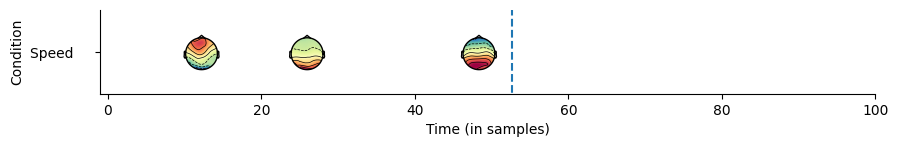

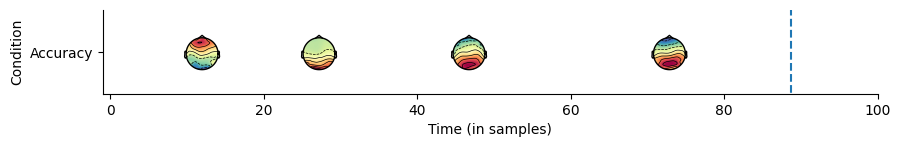

In [26]:
for condition in zip([fit_speed, fit_accuracy],
                     [model_speed, model_accuracy],
                     [hmp_speed_data, hmp_accuracy_data],
                    ['Speed    ', 'Accuracy']):
    hmp.visu.plot_topo_timecourse(eeg_data, condition[0],
                          positions, condition[1],  
                          times_to_display = np.mean(condition[1].ends - condition[1].starts),max_time=100,
                          figsize=(10,1), ylabels={'Condition':[condition[3]]})